In [48]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
sdg_indexes = pd.read_csv("data/sdg_prediction/sdg_indexes.csv")
sat_mod = pd.read_csv("data/sdg_prediction/sat_mod.csv")

## Setting up model 

In [3]:
sat_mod.columns

Index(['Unnamed: 0', 'id', 'lnEGDPpc2012', 'lnagr_land2012', 'lnurb_land2012',
       'ln_perUrb_land2012', 'ln_tr400_pop2012', 'ln_pm25_2012',
       'ln_land_temp2012', 'ln_t400NTLpc2012', 'ln_dist_road2017',
       'ln_ghsl2015', 'dist_diamond2015', 'ln_mal_inci_rt_mean',
       'ln_dist_water2017mean', 'ln_elev2017mean', 'ln_dist_drug2017mean'],
      dtype='object')

I would like to share my research progress until now. 

*The initial variables I used to train my model were: Agricultural land, Urban land, Land temp, population and NTL. This model had a predictive power of 30% when predicting the sustainable development index. After adding the Global Human settlement layer (GHSL) data it increased by almost 16% indicating that this dataset is an important predictor for SDI. 

*After introducing other variables such as: distance to drug cultivation, physical elevation, pm2.5 and distance to water the predictive power of the model is currently 53% before tuning the hyperparameters. 

*The hyperparameter tuning has been underwhelming until now increasing the R2 to 55%, only a 2% increase. Ill keep working on this regard while looking for better predictors. 

*Some predictors had a huge impact on individuals SDG indexes. For example "Physical Elevation" increased the predictive power for the sdg 2 and 13 went from less than 1% to 40%+ after adding this feature.  

Im still preparing a visualization that can help understand the changes made to the models 

In [127]:
#X = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012"]]
X = sat_mod[['ln_t400NTLpc2012', 'lnagr_land2012', 'lnurb_land2012','ln_land_temp2012','ln_tr400_pop2012','ln_dist_road2017','ln_ghsl2015', 
             "ln_dist_water2017mean",'ln_dist_drug2017mean', 'ln_elev2017mean', 'ln_pm25_2012']]
  #'dist_diamond2015', 
    # Elevation has a huge impact on 2 and 13 
y = sdg_indexes["imds"]

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = linear_model.Ridge()
model.fit(X_train, y_train);

print(model.score(X_test, y_test))

coeff = model.coef_
print("positive:")
print(np.array(X.columns)[coeff>2])
print("negative:")
print(np.array(X.columns)[coeff<-2])
print(model.coef_)


0.67569599438779
positive:
['lnurb_land2012' 'ln_ghsl2015']
negative:
['ln_tr400_pop2012' 'ln_elev2017mean' 'ln_pm25_2012']
[ 0.86020136  1.28777272  5.71602041 -1.8779711  -4.01675819 -1.17348359
  3.97961299  0.12663587 -1.53869912 -2.66044248 -6.7697645 ]


## Test for all labels 

In [117]:
ridge_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
ri_predict = pd.DataFrame()

In [118]:
y_variables = sdg_indexes[['index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4',
       'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9',
       'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15',
       'index_sdg16', 'index_sdg17', 'imds']]

In [119]:
x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012",'ln_dist_road2017' ,'ln_ghsl2015']]
# This ones make some sdg more relevant 
#
#x = X

for y_variable in y_variables:
    
    y = y_variables[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    ridge_model = linear_model.Ridge()

    r2 = np.mean(cross_val_score(ridge_model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(ridge_model, x, y, scoring="neg_mean_absolute_error"))
    
    ridge_results.loc[len(ridge_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    ridge_model.fit(x_train,y_train)
    y_pred = ridge_model.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if ri_predict.empty:
        ri_predict = temp_predict
    else:
        ri_predict = ri_predict.merge(temp_predict, on="id", how="outer")

In [120]:
ridge_results[ridge_results["r2"]>0.9].round(2)

,Feature,r2,MAE


In [121]:
ridge_results[ridge_results["r2"]>0.8].round(2)

,Feature,r2,MAE


In [122]:
ridge_results[(ridge_results["r2"]>=0.7) & (ridge_results["r2"]<0.8)].round(4)

,Feature,r2,MAE


In [123]:
ridge_results[(ridge_results["r2"]>=0.5) & (ridge_results["r2"]<0.7)].round(4)

,Feature,r2,MAE
0,index_sdg1,0.5500,-11.1636
6,index_sdg7,0.5062,-8.3764


In [124]:
ridge_results[ridge_results["r2"]>0 ].round(4)

,Feature,r2,MAE
0,index_sdg1,0.5500,-11.1636
1,index_sdg2,0.3064,-7.0602
2,index_sdg3,0.0254,-5.7717
3,index_sdg4,0.0981,-8.8868
4,index_sdg5,0.0209,-7.2948
5,index_sdg6,0.2741,-10.5752
6,index_sdg7,0.5062,-8.3764
7,index_sdg8,0.2752,-7.0311
8,index_sdg9,0.4911,-8.7928
9,index_sdg10,0.0648,-10.4756


In [116]:
ridge_results[ridge_results["r2"]<0].round(4)

,Feature,r2,MAE
2,index_sdg3,-0.0153,-5.8842
12,index_sdg15,-0.0589,-12.5402
13,index_sdg16,-0.0628,-7.4528


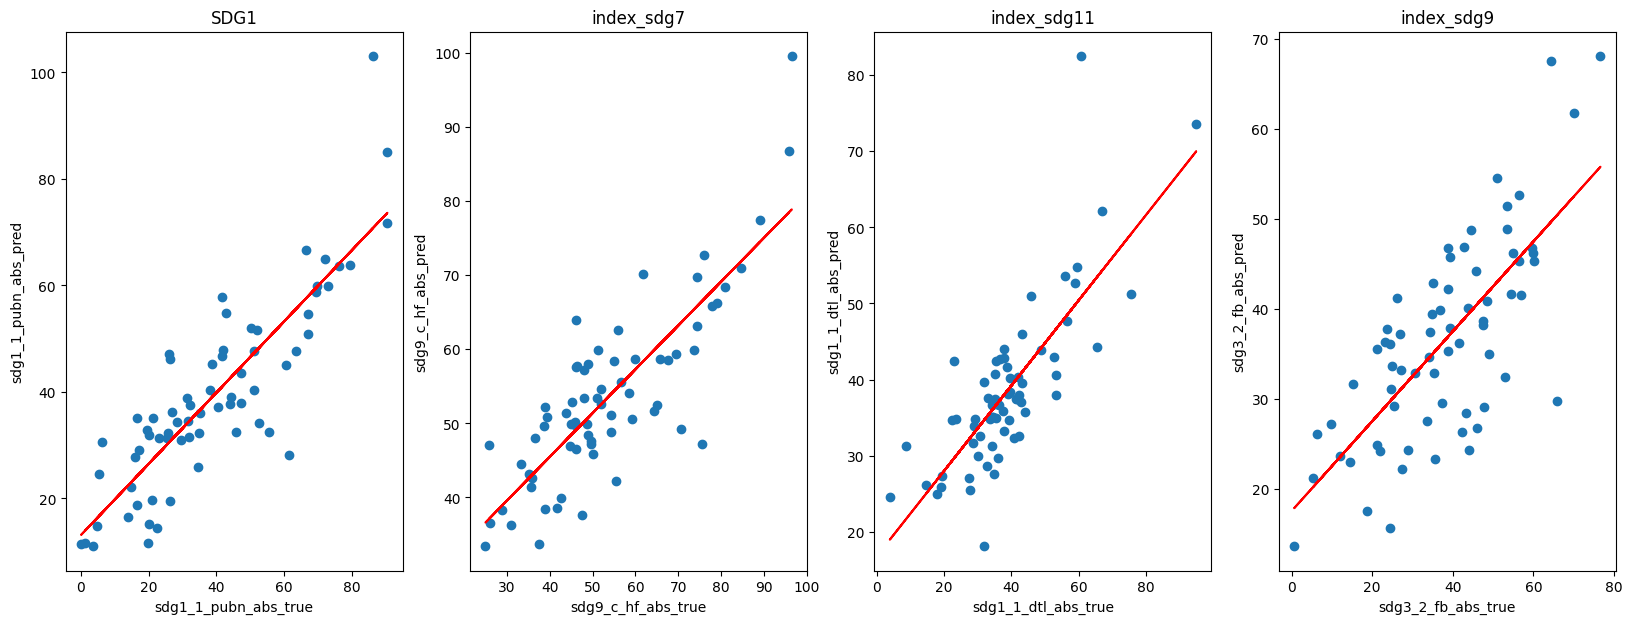

In [78]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = ri_predict["index_sdg1_true"]
g_y = ri_predict["index_sdg1_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="SDG1")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg7_true"]
g_y = ri_predict["index_sdg7_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg9_c_hf_abs_true", ylabel="sdg9_c_hf_abs_pred", title="index_sdg7")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg11_true"]
g_y = ri_predict["index_sdg11_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg1_1_dtl_abs_true", ylabel="sdg1_1_dtl_abs_pred", title="index_sdg11")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg9_true"]
g_y = ri_predict["index_sdg9_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg3_2_fb_abs_true", ylabel="sdg3_2_fb_abs_pred", title="index_sdg9")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")

# Adjust Hyperparameters

In [79]:
model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [80]:
model_tuned = linear_model.Ridge(alpha=0.0001, max_iter=1000)
model_tuned.fit(X_train, y_train);
model.score(X_test, y_test)


0.67569599438779

In [81]:
alpha_space = np.logspace(-4,0,30)
alpha_space

ridge_scores = []
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())

for alpha in alpha_space: 
    ridge_pipeline.alpha = alpha
    val = np.mean(cross_val_score(ridge_pipeline, X, y, cv = 10))
    ridge_scores.append(val)

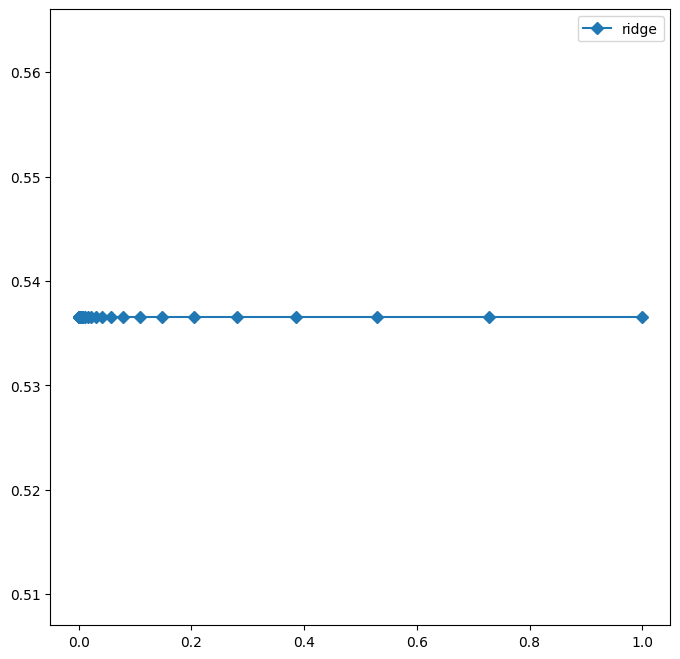

In [82]:
plt.figure(figsize=(8,8))
plt.plot(alpha_space, ridge_scores, marker="D", label = "ridge")
plt.legend()
plt.show()

In [83]:
def evaluate_preds(model, y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    r2 = np.mean(cross_val_score(model, X, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, X, y, scoring="neg_mean_absolute_error"))
    metric_dict = {"R2": round(r2, 2),
                   "MAE": round(mae, 2)}
    print(f"R2: {r2 * 100:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return metric_dict

In [84]:
grid = {"alpha": alpha_space,
        "copy_X": [True, False],
        "max_iter": [None, 10, 100, 200, 500, 1000, 10000], 
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]}

np.random.seed(42)
rs_rid_model= RandomizedSearchCV(estimator = model,
                                 param_distributions=grid,
                                 n_iter=100,
                                 cv=5,
                                 verbose=0)

rs_rid_model.fit(X_train, y_train);

In [85]:
rs_rid_model.best_params_

{'solver': 'auto',
 'max_iter': 200,
 'copy_X': True,
 'alpha': 0.0032903445623126675}

In [86]:
# Uses the best model for the prediction
rs_y_preds = rs_rid_model.predict(X_test)

rs_metrics = evaluate_preds(rs_rid_model, X, y)

R2: 55.02%
MAE: -3.57
